In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# 1. reload
csv_path = Path("Electric_Vehicle_Population_By_County.csv")
df_raw = pd.read_csv(csv_path)

# 2. universal numeric cleaner
def to_float(s):
    if pd.isna(s):
        return np.nan
    return float(str(s).replace(',', '').replace('"', ''))

numeric_cols = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles'
]
for col in numeric_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].apply(to_float)

# 3. datetime & lags
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%B %d %Y")
df_raw = df_raw.sort_values(['County', 'State', 'Date'])
df_raw['EV_Total_lag1'] = df_raw.groupby(['County', 'State'])['Electric Vehicle (EV) Total'].shift(1)
df_raw['EV_Total_lag2'] = df_raw.groupby(['County', 'State'])['Electric Vehicle (EV) Total'].shift(2)

# 4. keep clean rows
df = df_raw.dropna(subset=['EV_Total_lag1']).copy()

# 5. calendar features
df['Year']  = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

print("✅ df is ready – shape:", df.shape)

✅ df is ready – shape: (20367, 14)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import shap
import janitor
import dtale
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
# latest snapshot per county
latest = df.groupby(['County', 'State']).tail(1)

fig = px.choropleth(
    latest,
    locations='State',
    locationmode='USA-states',
    color='Electric Vehicle (EV) Total',
    hover_name='County',
    color_continuous_scale='Viridis',
    scope='usa',
    title='EV Totals by State (latest record per county)'
)
fig.show()

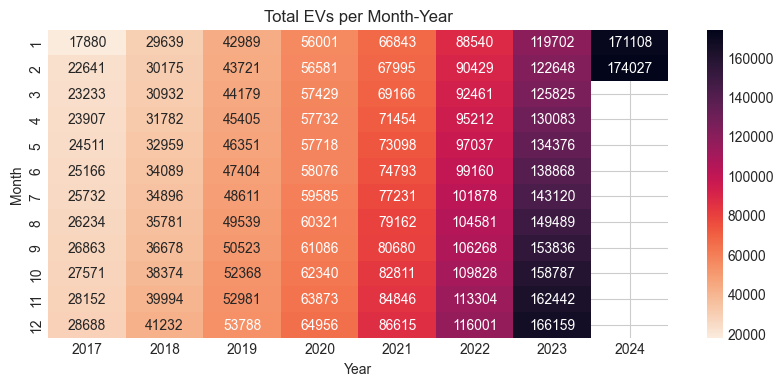

In [9]:
pivot = (df
         .assign(YearMonth=lambda d: d['Date'].dt.to_period('M'))
         .groupby(['YearMonth'])['Electric Vehicle (EV) Total']
         .sum()
         .reset_index())

pivot['Year']  = pivot['YearMonth'].dt.year
pivot['Month'] = pivot['YearMonth'].dt.month
heat = pivot.pivot(index='Month', columns='Year', values='Electric Vehicle (EV) Total')

plt.figure(figsize=(10,4))
sns.heatmap(heat, cmap='rocket_r', annot=True, fmt='.0f')
plt.title("Total EVs per Month-Year")
plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = ['EV_Total_lag1', 'EV_Total_lag2', 'Year', 'Month']
target   = 'Electric Vehicle (EV) Total'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_waterfall.py:67: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



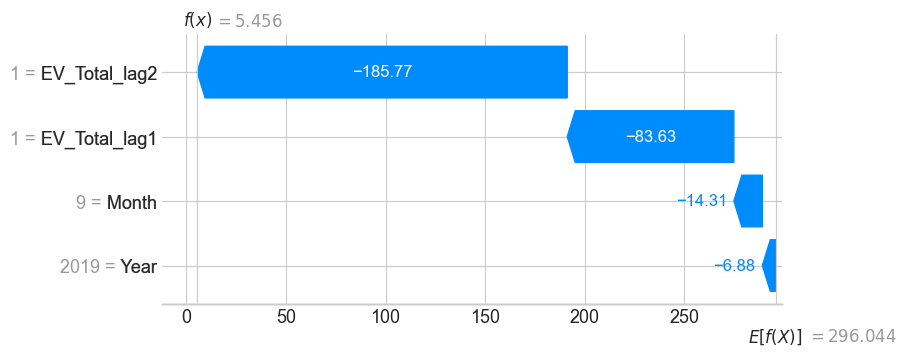

In [12]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# pick one row
sample_idx = 0
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns
    )
)

In [14]:
pred = rf.predict(X_test)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning:

The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:397: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.



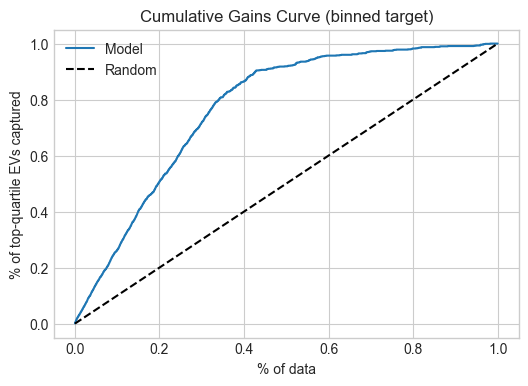

In [16]:
# Cumulative Gains for regression (no ROC)
from sklearn.preprocessing import KBinsDiscretizer

# bin into 4 quantiles
y_binned = KBinsDiscretizer(n_bins=4, encode='ordinal',
                            strategy='quantile',
                            subsample=None) \
             .fit_transform(y_test.values.reshape(-1, 1)) \
             .ravel()

# cumulative gains: % of data vs % of positive class captured
order = np.argsort(pred)[::-1]
y_true_sorted = (y_binned == y_binned.max()).astype(int)[order]

cum_pos = np.cumsum(y_true_sorted) / y_true_sorted.sum()
cum_pop = np.linspace(0, 1, len(y_true_sorted))

plt.figure(figsize=(6, 4))
plt.plot(cum_pop, cum_pos, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("Cumulative Gains Curve (binned target)")
plt.xlabel("% of data")
plt.ylabel("% of top-quartile EVs captured")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
d = dtale.show(df)
d.open_browser()

In [19]:
# Calculate feature importances
importances = pd.Series(rf.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

# Calculate feature importances
importances = pd.Series(rf.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

with PdfPages('EV_Report.pdf') as pdf:
    # 1. time-series
    fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='Date', y='Electric Vehicle (EV) Total', estimator='sum', ax=ax)
    ax.set_title("Total EVs over Time")
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # 2. feature importance
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(x=importances.values, y=importances.index, ax=ax, palette='GnBu_d')
    ax.set_title("Feature Importance")
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print("Saved EV_Report.pdf")

Saved EV_Report.pdf


C:\Users\adity\AppData\Local\Temp\ipykernel_23640\3900187275.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


